# HW 06: ETLs y ELTs on MBanco de Mexico and INEGI

## Introducción


## Objetivo

* Mostrar cómo se crea un ETL
* Mostrar cómo se crea un ELT
* Mostrar cómo se utilizan los servicios Amazon S3, AWS Glue y Amazon Athena 
para tareas de ingeniería de datos y analítica.

## Herramientas que aprenderas a utilizar:

#

In [1]:
# Importar librerías
import os
import pandas as pd
import numpy as np

import requests
import json
from sie_banxico import SIEBanxico

# ELT

Ahora que ya subimos los datos al data lake, podemos utilizarlos para hacer
nuestros análisis o aplicaciones.

En esta sección vamos a utilizar Amazon Athena para hacer transformaciones a 
nuestros datos crudos y cargarlos en nuestro ambiente de Python local para 
hacer los análisis que necesitemos.

Para poder utilizar Amazon Athena, por primera vez, tenemos que configurar un
bucket en Amazon S3 donde se puedan guardar nuestras queries. Esto lo podemos
hacer siguiendo estas instrucciones:

* [Specifying a query result location using the Athena console](https://docs.aws.amazon.com/athena/latest/ug/querying.html#query-results-specify-location-console)

Este paso lo tenemos que hacer una sola vez.

Una vez configurado, para usar nuestros datos en Amazon Athena, lo que tenemos
que hacer es crear una base de datos en AWS Glue Catalog, que lo que hace es
llevar un catálogo de todas las tablas que tenemos en data lake, y que podemos
utilizar rápidamente con otros servicios en la nube.

Después solo tenemos que crear el schema de las tablas y agregarlas a la base 
de datos que creamos. Una vez hecho esto podemos realizar las operaciones en
SQL sobre nuestros datos.


In [ ]:
# Load the CSV files into pandas dataframes
df_inflacion = pd.read_csv('data/raw/inflacion.csv')
df_tasa_de_interes = pd.read_csv('../../data/raw/tasa_de_interes.csv')
df_tipo_de_cambio = pd.read_csv('../../data/raw/tipo_de_cambio.csv')

# Merge the dataframes on the 'period' column
df_merged = df_inflacion.merge(df_tasa_de_interes, on='period', how='left')
df_merged = df_merged.merge(df_tipo_de_cambio, on='period', how='left')

# Save the merged dataframe to a new CSV file
df_merged.to_csv('../../data/processed/united_table.csv', index=False)

## Configuración 

Sigamos paso a paso cada uno de los pasos descritos anteriormente.

### Crear una base de datos en el Glue Catalog

Para crear la base de datos en AWS Glue Catalog, primero tenemos que llamar
al cliente de Glue.

Aqui te dejo la [documentación](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html) para que veas que funciones puedes llamar de 
este servicio.

In [11]:
# Abres un cliente de S3
import boto3
session = boto3.Session(profile_name='arquitectura', 
                        region_name='us-east-1') ## added this line to define the region
s3 = session.client('s3')

In [12]:
from botocore.config import Config
my_config = Config(
    region_name = 'us-east-1'
)

glue = boto3.client('glue', config=my_config)

Vamos a llamar la función `create_database`, que necesita un nombre
y una descripción.

In [13]:
response = glue.create_database(
    DatabaseInput={
        'Name': 'econ',
        'Description': 'Contains data about exchange rate mxn-usd, infaltion and interes rate obtained form Banco de Mexico and INEGI.',
    },
)
response

AlreadyExistsException: An error occurred (AlreadyExistsException) when calling the CreateDatabase operation: Database already exists.

**NOTA**: Si no puedes correr esta línea porque no encuentras la sesión las credenciales, entonces entra a la consola de AWS, y crea la database desde el servicio de Glue.

Los pasos que tienes que seguir son:

* Entra a tu cuenta de AWS
* Navega al servicio de Glue.
* En el menú izquierdo buscao catalog, y luego databases.
* En databases, crea una nueva base de datos.
* Ingresa el `name` y el `description`, toma como referncia los valores que tienes en la celda de arriba.


### Configurar Athena

Necesitamos crear un bucket al que podamos apuntar nuestras queries en 
Amazon Athena. Recuerda poner un nombre único a tu bucket. En este caso puedes
poner `arquitectura-athena-queries-MINOMBRE`

In [ ]:
s3.create_bucket(Bucket="arquitectura-athena-queries-thmrrudolf")

{'ResponseMetadata': {'RequestId': 'PQMT7ZEJGRX5TNXP',
  'HostId': 'J/3vJ3EaLvioCRAI5eeO65oIlswykb5T/m17wlkGMzShuOXpXlKJytEd+ji9X3FjkMklZh1DG1o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'J/3vJ3EaLvioCRAI5eeO65oIlswykb5T/m17wlkGMzShuOXpXlKJytEd+ji9X3FjkMklZh1DG1o=',
   'x-amz-request-id': 'PQMT7ZEJGRX5TNXP',
   'date': 'Wed, 19 Mar 2025 02:36:16 GMT',
   'location': '/arquitectura-athena-queries-thmrrudolf',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/arquitectura-athena-queries-thmrrudolf'}

## a) Extract y b) Load

### Crear tablas en la base de datos de nuestros CSVs en el data lake

- **Season Guests Table**

In [ ]:
import awswrangler as wr

In [ ]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `hw06`.`inflation` (
    `period` string,
    `inflacion` float
    ) COMMENT "Catalog of inflation rate"
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-thmrudolf/hw06/raw/inflacion/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''
print(session)

Session(region_name='us-east-1')


In [ ]:
query = '''
    CREATE TABLE IF NOT EXISTS hw06.united_table AS (
        SELECT 
            i.period,
            i.inflacion,
            t.tasa_de_interes,
            c.tipo_de_cambio
        FROM hw06.inflation AS i
        LEFT JOIN hw06.tasa_de_interes AS t
        ON i.period = t.period
        LEFT JOIN hw06.cambio AS c
        ON i.period = c.period
    )COMMENT "Catalog of inflation rate"
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-thmrudolf/hw06/raw/inflacion/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

wr.athena.read_sql_query(
    query, 
    database="hw06", 
    ctas_approach=False,
    boto3_session=session
)

InvalidRequestException: An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: line 12:6: mismatched input 'COMMENT'. Expecting: '%', ')', '*', '+', ',', '-', '.', '/', 'AND', 'AT', 'CROSS', 'EXCEPT', 'FETCH', 'FULL', 'GROUP', 'HAVING', 'INNER', 'INTERSECT', 'JOIN', 'LEFT', 'LIMIT', 'NATURAL', 'OFFSET', 'OR', 'ORDER', 'RIGHT', 'UNION', 'WHERE', 'WINDOW', 'WITH', '[', '||', <EOF>

In [ ]:
wr.athena.read_sql_query(
    query, 
    database="hw06", 
    ctas_approach=False, 
    boto3_session=session
)

""


- **Seasons Table**

In [ ]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `hw06`.`exchange` (
    `period` string,
    `inflacion` float
    ) COMMENT "Catalog of Simpsons seasons."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-thmrudolf/hw06/raw/exchange/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [ ]:
wr.athena.read_sql_query(
    query, 
    database="simpsons", 
    ctas_approach=False, 
    boto3_session=session
)

""


## c) Transform

In [ ]:
query = '''
    CREATE TABLE IF NOT EXISTS simpsons.guests_per_season AS (
        SELECT 
            LPAD(a.season, 2, '0') AS season,
            a.episodes,
            a.viewer,
            SUBSTRING(a.first_aired, 1, 4) AS year_aired,
            b.guest_star
        FROM simpsons.seasons AS a
        LEFT JOIN simpsons.guests AS b
        ON a.season = b.season
    )
'''

wr.athena.read_sql_query(
    query, 
    database="simpsons", 
    ctas_approach=False,
    boto3_session=session
)

""


: 

: 

## Analytics

In [ ]:
query = '''SELECT * FROM simpsons.guests_per_season'''

: 

: 

In [ ]:
tbl_guests_per_season = wr.athena.read_sql_query(
    query, 
    database="simpsons", 
    ctas_approach=False,
    boto3_session=session
)

: 

: 

In [ ]:
tbl_guests_per_season.fillna('0')

,season,episodes,viewer,year_aired,guest_star
0,01,13,14.5,1989,0
1,02,22,8.0,1990,0
2,03,24,0,1991,0
3,04,22,13.0,1992,0
4,05,22,0,1993,0
...,...,...,...,...,...
761,34,22,0.65,2022,Anna Faris
762,34,22,0.65,2022,Joe Mantegna
763,34,22,0.65,2022,Jane Kaczmarek
764,34,22,0.65,2022,Jay Pharoah


: 

: 

In [ ]:
tbl_seasons_with_no_guests = (
    tbl_guests_per_season
        .query('guest_star.isna()')
        .drop_duplicates()
        .assign(num_guests = 0)
        .rename(columns={'viewer': 'viewers'})
        .filter(['season', 'year_aired', 'num_guests','viewers'])
        .fillna('0')
        .assign(viewers = lambda x: x.viewers.astype(float))
)
tbl_seasons_with_no_guests

,season,year_aired,num_guests,viewers
0,01,1989,0,14.5
1,02,1990,0,8.0
2,03,1991,0,0.0
3,04,1992,0,13.0
4,05,1993,0,0.0
5,06,1994,0,0.0
6,07,1995,0,0.0
7,08,1996,0,0.0
8,09,1997,0,9.2
9,10,1998,0,0.0


: 

: 

In [ ]:
tbl_seasons_with_guests = (
    # Calculate n_guests
    tbl_guests_per_season
        .assign(viewer = lambda df_: df_.viewer.astype('float'))
        .query('~guest_star.isna()')
        .groupby(['season', 'year_aired'])
        .size()
        .to_frame(name = 'num_guests')
        .reset_index()
        .merge(
            # Calculate viewers
            tbl_guests_per_season
                .assign(viewer = lambda df_: df_.viewer.astype('float'))
                .query('~guest_star.isna()')
                .groupby(['season', 'year_aired'])
                ['viewer']
                .mean()
                .to_frame(name = 'viewers')
                .reset_index()
        )
        .fillna(0)
)
tbl_seasons_with_guests.head()

,season,year_aired,num_guests,viewers
0,21,2009,49,3.4
1,22,2010,61,3.3
2,23,2011,58,3.3
3,24,2012,65,2.9
4,25,2013,44,0.0


: 

: 

In [ ]:
tbl_season_guests = (
    pd.concat([tbl_seasons_with_no_guests, tbl_seasons_with_guests], ignore_index=True)
        .sort_values(['season', 'year_aired'])
        .assign(
            num_guests=lambda df_: df_.num_guests.astype('float'), 
            viewers=lambda df_: df_.viewers.astype('float'))
        )
tbl_season_guests.head()

,season,year_aired,num_guests,viewers
0,01,1989,0.0,14.5
1,02,1990,0.0,8.0
2,03,1991,0.0,0.0
3,04,1992,0.0,13.0
4,05,1993,0.0,0.0


: 

: 

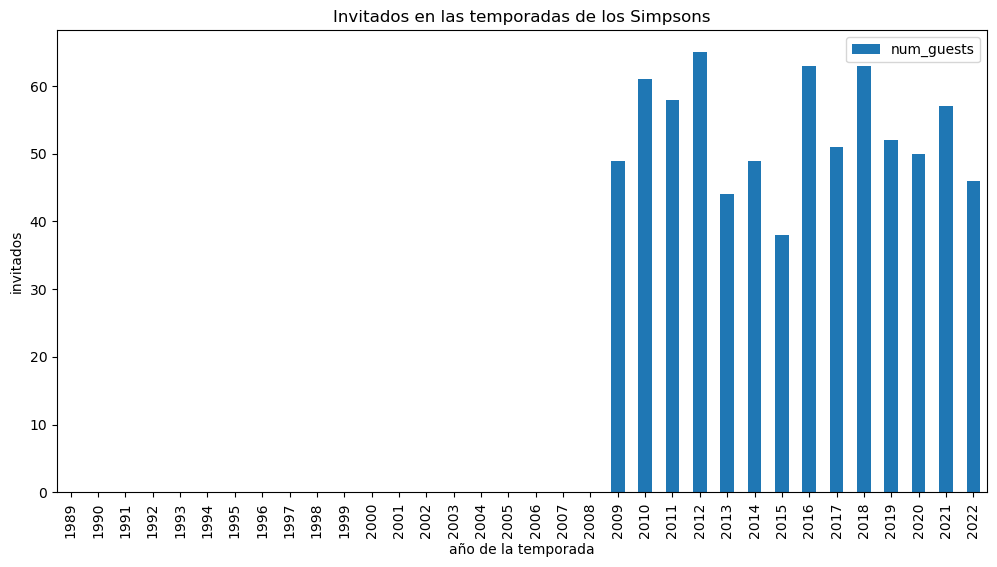

: 

: 

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 6))
tbl_season_guests.plot(
    kind='bar', 
    x='year_aired', 
    y='num_guests', 
    ax = ax
)
plt.title("Invitados en las temporadas de los Simpsons")
plt.ylabel('invitados')
plt.xlabel('año de la temporada')
plt.show()

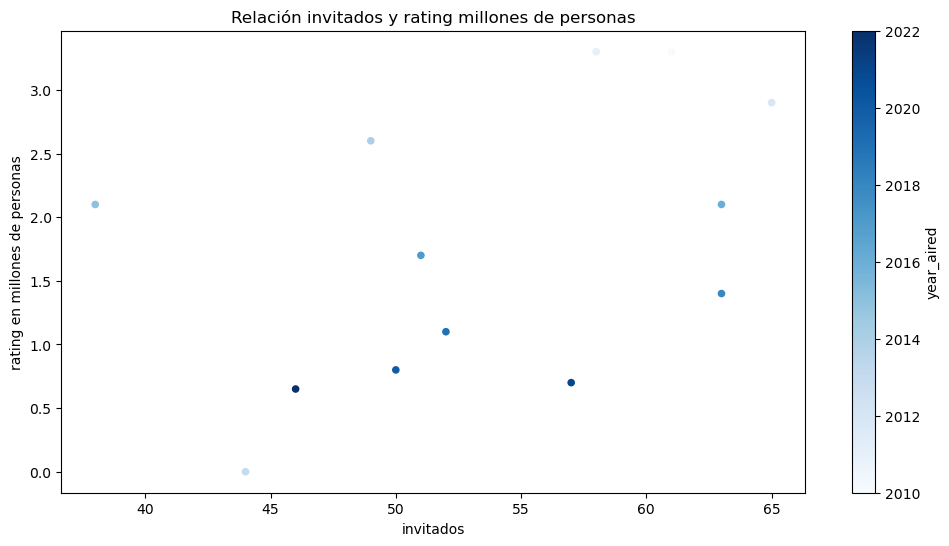

: 

: 

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
(tbl_season_guests
    .assign(year_aired = lambda df_: df_.year_aired.astype('int'))
    .query('year_aired > 2009')
    .plot(
        kind='scatter', 
        x='num_guests', 
        y='viewers', 
        c='year_aired', 
        cmap='Blues', 
        ax=ax)
    )
plt.title("Relación invitados y rating millones de personas")
plt.ylabel('rating en millones de personas')
plt.xlabel('invitados')
plt.show()